In [1]:
import os
# Find the latest version of spark 3.0  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
spark_version = 'spark-3.0.3'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

!wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("MachineLearningIntegration").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [76.8 kB]
Hit:13 http://ppa.launchpad.net/cran/

In [2]:
!pip install prophet

     |████████████████████████████████| 65 kB 3.3 MB/s 
     |████████████████████████████████| 49 kB 6.4 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6639800 sha256=9c6cdd92fac43047d915ed7ca1a9af6b55e58b7fa9f7de9035dea72c3899f49e
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [3]:
# dependecies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy.stats import linregress
from statsmodels.tsa.holtwinters import ExponentialSmoothing as ETS
from statsmodels.tools.eval_measures import mse
from statsmodels.tools.eval_measures import meanabs
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from pandas import to_datetime
from pandas.tseries.offsets import DateOffset as DateOffset
from datetime import datetime
import itertools
import findspark
from pyspark.sql import SparkSession
from pyspark import SparkFiles
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# access local data
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# filepath
# path_1 = "Data/BicycleSales_2016-2021_cleaned.xlsx"
path_1 = '/content/gdrive/MyDrive/School/Georgia Tech/Data Science & Analytics Bootcamp/GT_DS_HW/Project-4_MachineLearningIntegration/Data/BicycleSales_2014-2021_redacted.xlsx'

# read data
sales_df = pd.read_excel(path_1)

In [ ]:
# group and pivot invoiced quantity by date and material
# split Month into separate month and year components
sales_df[["Month", "Year"]] = sales_df["Month"].str.split("/", n=1, expand=True)

# create Date column with reordered Year/Month format
sales_df["Month"] = sales_df["Year"] + "-" + sales_df["Month"]

# group by date, sold-to, material
sales_gb_df = sales_df.groupby(
    ['Month', "Material"])[["Invoiced Quantity"]].sum()

print(sales_gb_df)

In [ ]:
# pivot sold to and material
sales_pivot_df = pd.pivot_table(sales_gb_df,
                           values = 'Invoiced Quantity',
                           index = 'Month',
                           columns = 'Material',
                           aggfunc=np.sum,
                           fill_value = 0
                                )

sales_pivot_df = sales_pivot_df.reset_index()
sales_pivot_df['Month'] = to_datetime(sales_pivot_df['Month'])
sales_pivot_df = sales_pivot_df.set_index(['Month'])

print(sales_pivot_df)

Material    IB00026200  IB00026400  ...  TB97613100  TB97613200
Month                               ...                        
2014-01-01           0           0  ...           0           0
2014-02-01           0           0  ...           0           0
2014-03-01           0           0  ...           0           0
2014-04-01           0           0  ...           0           0
2014-05-01           0           0  ...           0           0
...                ...         ...  ...         ...         ...
2021-08-01           0           0  ...           0           0
2021-09-01           0           0  ...           0           0
2021-10-01           0           0  ...           0           0
2021-11-01           0           0  ...           0           0
2021-12-01           0           0  ...           0           0

[96 rows x 939 columns]


In [ ]:
sales_1_df = sales_pivot_df[['TB96805000']]
sales_1_df.rename(columns={'TB96805000':'Sales'}, inplace = True)
# sales_1_df.to_csv("Output/Sales.csv")

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
sales_1_df

Material,Sales
Month,
2014-01-01,0
2014-02-01,0
2014-03-01,125
2014-04-01,35
2014-05-01,28
...,...
2021-08-01,3127
2021-09-01,0
2021-10-01,0


In [ ]:
# dataframe format for prophet
# df = sales_1_df.iloc[:,each].to_frame().reset_index()
# material = df.columns[1]
df = sales_1_df.reset_index()
df.columns = ['ds', 'y']
df['floor'] = -.001
df['cap'] = 30000

### Prohpet

In [ ]:
m = Prophet(seasonality_mode='additive')

m.fit(df)
future = m.make_future_dataframe(periods=24, freq='M')

fcst = m.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
prophet_df = fcst[{'ds', 'yhat'}]
prophet_df.columns = ['Month', 'Prophet']
prophet_df = prophet_df.set_index(['Month'])
prophet_df['Prophet'] = prophet_df['Prophet'].round(decimals=0)
prophet_df['Prophet'] = prophet_df['Prophet'].apply(np.int64)
# prophet_df.to_csv("Output/Prophet.csv")
prophet_df

,Prophet
Month,
2014-01-01,-65
2014-02-01,-52
2014-03-01,-92
2014-04-01,27
2014-05-01,122
...,...
2023-07-31,402
2023-08-31,395
2023-09-30,702


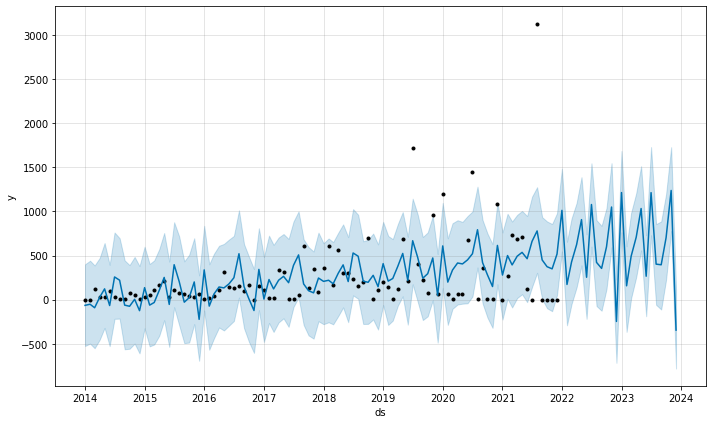

In [ ]:
# plot
fig = m.plot(fcst)

In [ ]:
# performance
cutoffs = pd.to_datetime(['2018-12-01'])
df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days', period='365 days', parallel="processes")

df_cv

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fef36e26a90>


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-01-01,287.102927,124.039843,460.554661,199,2018-12-01
1,2019-02-01,292.634770,112.362136,475.155694,138,2018-12-01
2,2019-03-01,295.223589,112.787827,462.159447,9,2018-12-01
3,2019-04-01,302.986127,136.136091,474.187524,125,2018-12-01
4,2019-05-01,307.069423,125.339052,471.358702,690,2018-12-01
5,2019-06-01,310.361404,126.718023,478.736132,215,2018-12-01
6,2019-07-01,314.930067,138.614380,493.723450,1717,2018-12-01
7,2019-08-01,319.681923,141.256508,505.516163,407,2018-12-01
8,2019-09-01,326.810151,152.414693,506.795658,222,2018-12-01
9,2019-10-01,332.481803,153.896497,508.271403,71,2018-12-01


In [ ]:
df_p = performance_metrics(df_cv, rolling_window=1)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,731 days,252661.829047,502.654781,385.414576,12.011465,0.968562,1.093988,0.291667


In [ ]:
# Hyperparameter tuning
param_grid = {  
    'changepoint_prior_scale': [0.001, .005, 0.01, 0.05, 0.1],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10],
    'seasonality_mode': ['additive', 'multiplicative'],
    'growth': ['logistic']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    cutoffs = pd.to_datetime(['2018-12-01'])
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days', period='365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fef37023710>
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fef3716f250>
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fef37180bd0>
INFO:prophet:Disabling weekly seasonality. Run prophet 

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,growth,rmse
0,0.001,0.01,additive,logistic,475.392553
1,0.001,0.01,multiplicative,logistic,473.725044
2,0.001,0.10,additive,logistic,489.151464
3,0.001,0.10,multiplicative,logistic,529.329408
4,0.001,1.00,additive,logistic,490.186791
5,0.001,1.00,multiplicative,logistic,617.189535
6,0.001,10.00,additive,logistic,492.463060
7,0.001,10.00,multiplicative,logistic,756.070989
8,0.005,0.01,additive,logistic,475.322269
9,0.005,0.01,multiplicative,logistic,473.835744


In [ ]:
# Identify best hyperparameter
best_parameters = tuning_results.iloc[tuning_results['rmse'].idxmin(),:]
cps = best_parameters['changepoint_prior_scale']
sps = best_parameters['seasonality_prior_scale']
sm = best_parameters['seasonality_mode']
growth = best_parameters['growth']
best_parameters

changepoint_prior_scale             0.001
seasonality_prior_scale              0.01
seasonality_mode           multiplicative
growth                           logistic
rmse                           473.725044
Name: 1, dtype: object

In [ ]:
m = Prophet(seasonality_mode=sm, changepoint_prior_scale=cps, seasonality_prior_scale=sps)

m.fit(df)
future = m.make_future_dataframe(periods=24, freq='M')

fcst_tuned = m.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
prophet_tuned_df = fcst_tuned[{'ds', 'yhat'}]
prophet_tuned_df.columns = ['Month', 'Prophet_tuned']
prophet_tuned_df = prophet_tuned_df.set_index(['Month'])
prophet_tuned_df['Prophet_tuned'] = prophet_tuned_df['Prophet_tuned'].round(decimals=0)
prophet_tuned_df['Prophet_tuned'] = prophet_tuned_df['Prophet_tuned'].apply(np.int64)
# prophet_df.to_csv("Output/Prophet.csv")
prophet_tuned_df

,Prophet_tuned
Month,
2014-01-01,-18
2014-02-01,-12
2014-03-01,-7
2014-04-01,-1
2014-05-01,4
...,...
2023-07-31,631
2023-08-31,631
2023-09-30,636


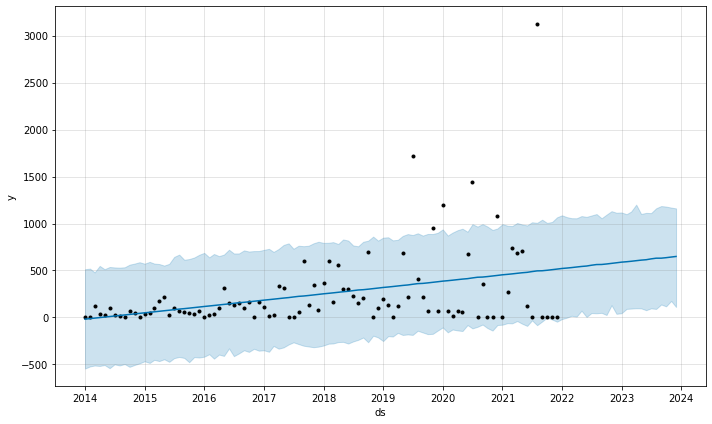

In [ ]:
# plot
fig = m.plot(fcst_tuned)

In [ ]:
# performance
cutoffs = pd.to_datetime(['2018-12-01'])
df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days', period='365 days', parallel="processes")

df_cv

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fef36f3fe50>


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-01-01,287.102927,124.039843,460.554661,199,2018-12-01
1,2019-02-01,292.634770,112.362136,475.155694,138,2018-12-01
2,2019-03-01,295.223589,112.787827,462.159447,9,2018-12-01
3,2019-04-01,302.986127,136.136091,474.187524,125,2018-12-01
4,2019-05-01,307.069423,125.339052,471.358702,690,2018-12-01
5,2019-06-01,310.361404,126.718023,478.736132,215,2018-12-01
6,2019-07-01,314.930067,138.614380,493.723450,1717,2018-12-01
7,2019-08-01,319.681923,141.256508,505.516163,407,2018-12-01
8,2019-09-01,326.810151,152.414693,506.795658,222,2018-12-01
9,2019-10-01,332.481803,153.896497,508.271403,71,2018-12-01


In [ ]:
df_p = performance_metrics(df_cv, rolling_window=1)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,365 days,234471.677232,484.222756,327.87234,3.812936,0.733382,0.877879,0.416667


### load to postgres RDS

In [ ]:
#Create PySpark DataFrame from Pandas
prophet_sparkDF=spark.createDataFrame(prophet_df.reset_index()) 
prophet_sparkDF.printSchema()
prophet_sparkDF.show()

root
 |-- Month: timestamp (nullable = true)
 |-- Prophet: long (nullable = true)

+-------------------+-------+
|              Month|Prophet|
+-------------------+-------+
|2014-01-01 00:00:00|    -65|
|2014-02-01 00:00:00|    -52|
|2014-03-01 00:00:00|    -92|
|2014-04-01 00:00:00|     27|
|2014-05-01 00:00:00|    122|
|2014-06-01 00:00:00|    -67|
|2014-07-01 00:00:00|    257|
|2014-08-01 00:00:00|    220|
|2014-09-01 00:00:00|    -62|
|2014-10-01 00:00:00|    -75|
|2014-11-01 00:00:00|      4|
|2014-12-01 00:00:00|   -125|
|2015-01-01 00:00:00|    136|
|2015-02-01 00:00:00|    -62|
|2015-03-01 00:00:00|    -32|
|2015-04-01 00:00:00|    107|
|2015-05-01 00:00:00|    252|
|2015-06-01 00:00:00|    -54|
|2015-07-01 00:00:00|    396|
|2015-08-01 00:00:00|    204|
+-------------------+-------+
only showing top 20 rows



In [ ]:
#Create PySpark DataFrame from Pandas
sales_1_sparkDF=spark.createDataFrame(sales_1_df.reset_index()) 
sales_1_sparkDF.printSchema()
sales_1_sparkDF.show()

root
 |-- Month: timestamp (nullable = true)
 |-- Sales: long (nullable = true)

+-------------------+-----+
|              Month|Sales|
+-------------------+-----+
|2014-01-01 00:00:00|    0|
|2014-02-01 00:00:00|    0|
|2014-03-01 00:00:00|  125|
|2014-04-01 00:00:00|   35|
|2014-05-01 00:00:00|   28|
|2014-06-01 00:00:00|   97|
|2014-07-01 00:00:00|   27|
|2014-08-01 00:00:00|   13|
|2014-09-01 00:00:00|    8|
|2014-10-01 00:00:00|   74|
|2014-11-01 00:00:00|   50|
|2014-12-01 00:00:00|    4|
|2015-01-01 00:00:00|   34|
|2015-02-01 00:00:00|   49|
|2015-03-01 00:00:00|  106|
|2015-04-01 00:00:00|  171|
|2015-05-01 00:00:00|  214|
|2015-06-01 00:00:00|   25|
|2015-07-01 00:00:00|  106|
|2015-08-01 00:00:00|   73|
+-------------------+-----+
only showing top 20 rows



In [ ]:
#Create PySpark DataFrame from Pandas
prophet_tuned_sparkDF=spark.createDataFrame(prophet_tuned_df.reset_index()) 
prophet_tuned_sparkDF.printSchema()
prophet_tuned_sparkDF.show()

root
 |-- Month: timestamp (nullable = true)
 |-- Prophet_tuned: long (nullable = true)

+-------------------+-------------+
|              Month|Prophet_tuned|
+-------------------+-------------+
|2014-01-01 00:00:00|          -18|
|2014-02-01 00:00:00|          -12|
|2014-03-01 00:00:00|           -7|
|2014-04-01 00:00:00|           -1|
|2014-05-01 00:00:00|            4|
|2014-06-01 00:00:00|           10|
|2014-07-01 00:00:00|           16|
|2014-08-01 00:00:00|           21|
|2014-09-01 00:00:00|           27|
|2014-10-01 00:00:00|           32|
|2014-11-01 00:00:00|           38|
|2014-12-01 00:00:00|           44|
|2015-01-01 00:00:00|           50|
|2015-02-01 00:00:00|           55|
|2015-03-01 00:00:00|           60|
|2015-04-01 00:00:00|           66|
|2015-05-01 00:00:00|           72|
|2015-06-01 00:00:00|           77|
|2015-07-01 00:00:00|           83|
|2015-08-01 00:00:00|           89|
+-------------------+-------------+
only showing top 20 rows



In [ ]:
# Configure settings for RDS
mode = "overwrite"
jdbc_url="jdbc:postgresql://database-1.cc8swew422eu.us-east-1.rds.amazonaws.com:5432/postgres"
config = {"user":"pgadmin", 
          "password": "postgres", 
          "driver":"org.postgresql.Driver"}

In [ ]:
# Write DataFrame to prophet table in RDS

prophet_sparkDF.write.jdbc(url=jdbc_url, table='prophet', mode=mode, properties=config)
sales_1_sparkDF.write.jdbc(url=jdbc_url, table='sales', mode=mode, properties=config)
prophet_tuned_sparkDF.write.jdbc(url=jdbc_url, table='prophet_tuned', mode=mode, properties=config)

# JAE START HERE

### ETS

In [ ]:
# Add 24 timeperiods to the DF
test_df = sales_1_df.reset_index()
n = 24
last_dt = test_df['Month'].iloc[-1]
future = []
for i in range (1, n+1):
    next_dt = last_dt + pd.DateOffset(months = i)
    # next_dt = pd.to_datetime
    # dt_object = datetime.fromtimestamp(next_dt)
    future.append(next_dt)

In [ ]:
future
a_series = pd.Series(to_append, index = df.columns)
df = df.append(a_series, ignore_index=True)

TypeError: ignored

In [ ]:

# last_dt = merge_gb_pivot['Month'].iloc[-1]
# next_dt = last_dt + DateOffset(months=+10)
# next_dt.dtype

In [ ]:
# 3 adding 1 to everything to remove 0 as the model cannot accept 0s
test_df = merge_gb_pivot[['TB96805000']] + 1
# test_df = test_df.append()
print(test_df)

Material  TB96793100
0                112
1                111
2                417
3                 34
4                706
..               ...
67               102
68                 1
69                 1
70               571
71                71

[72 rows x 1 columns]


In [ ]:
test_df.index.freq = 'MS'
train = test_df.iloc[:60, 0] 
test = test_df.iloc[60:, 0]
model = ETS(train, 
                             trend='add', 
                             damped_trend=True, 
                             seasonal='add', 
                             seasonal_periods=24).fit()

TypeError: ignored

In [ ]:
print(test)

60       1
61    2035
62      31
63      31
64     522
65     492
66       1
67     102
68       1
69       1
70     571
71      71
Name: TB96793100, dtype: int64


In [ ]:
holt_pred = model.predict(start=test.index[0], end=test.index[-1])

In [ ]:
print(holt_pred)

60     272.762792
61     299.281903
62     560.358760
63     489.579224
64     890.168165
65     729.649069
66     770.089312
67    2263.950708
68    1185.264157
69     453.769561
70     128.858477
71     -33.139465
dtype: float64


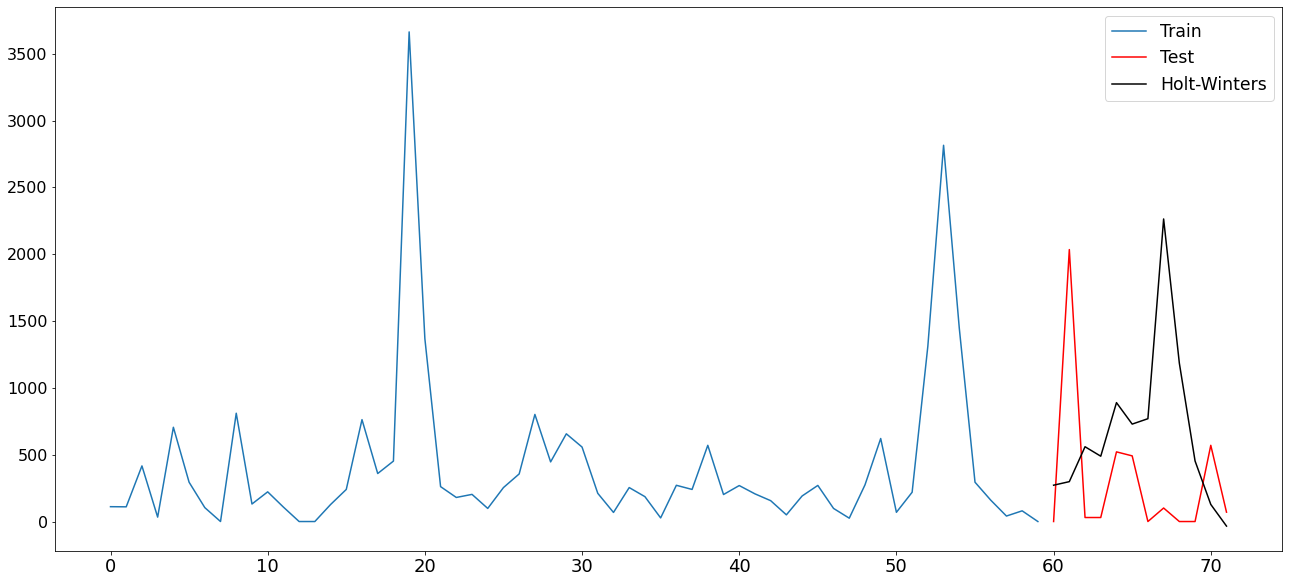

In [ ]:
plt.figure(figsize=(22, 10))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='r')
plt.plot(holt_pred.index, holt_pred, label='Holt-Winters', color='k')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

# Scratch

In [ ]:
# iterate through each column and apply PROPHET method
# for each in range(sales_df_pivot.shape[1]):
#     df['ds'] = sales_df_pivot['Date']
#     y = sales_df_pivot.iloc([:, each])
#     df['y'] = y

for each in range(merge_gb_pivot.shape[1]):
    m = Prophet(seasonality_mode='multiplicative')
    df = merge_gb_pivot.iloc[:,each].to_frame().reset_index()
    material = df.columns[1]
    df.columns = ['ds', 'y']
    m.fit(df)
    future = m.make_future_dataframe(periods=24, freq='MS')

    fcst = m.predict(future)
#     fig = m.plot(fcst)
    fcst[{'ds', 'yhat'}]
    
    df2 = fcst[{'ds', 'yhat'}]
    df2.columns = [material, 'Month']
    df2[material] = df2[material].round(0).astype(int)
    df2.set_index('Date')
    
    df3 = merge_gb_pivot.merge(df2, on='Date', how='outer', suffixes=(None,'_y'))
    df3[material] = df3.loc[df3[material] == np.NaN, material] = df3[material+'_y']
    df3 = df3.drop(columns=[material+'_y'])
    
    df3.to_csv("Data/TW_AM_24mo_Prophet_FCST.csv")

ParserError: day is out of range for month: 0

In [ ]:
df3.head(20)

,Date,IB00095000,IB00095100,IB00099900,IB00100000,IB00136200,IB00137300,IB00139800,IB00140000,IB00140200,...,TB96906000,TB96906100,TB96908000,TB96908100,TB96909000,TB96909100,TB96910000,TB96910100,TB96962000,TB96962100
0,2016-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-38
1,2016-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-58
2,2016-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-11
3,2016-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
4,2016-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,90.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5,2016-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4
6,2016-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,101.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
7,2016-08-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,351.0,377.0,0.0,30.0,0.0,30.0,0.0,30.0,0.0,0
8,2016-09-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100.0,393.0,62.0,116.0,115.0,110.0,130.0,75.0,0.0,0
9,2016-10-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,25.0,312.0,406.0,307.0,386.0,301.0,320.0,0.0,-2


In [ ]:
df3 = pd.read_csv("Data/TW_AM_24moFCST.csv")
df3.dtypes

Unnamed: 0      int64
Date           object
IB00095000    float64
IB00095100    float64
IB00099900    float64
               ...   
TB96909100    float64
TB96910000    float64
TB96910100    float64
TB96962000    float64
TB96962100      int64
Length: 366, dtype: object

In [ ]:
### 

In [ ]:
# Below is just reference

In [ ]:
# pivot sold to and material
sales_df_pivot = pd.pivot_table(sales_df_gb,
                           values = 'Invoiced Quantity',
                           index = 'Date',
                           columns = 'Material',
                           aggfunc=np.sum,
                           fill_value = 0
                                )

sales_df_pivot = sales_df_pivot.reset_index()
sales_df_pivot['Date'] = to_datetime(sales_df_pivot['Date'])
sales_df_pivot = sales_df_pivot.set_index('Date')
sales_df_pivot.head()

Material,IB00026200,IB00026400,IB00026500,IB00041800,IB00095000,IB00095100,IB00099900,IB00100000,IB00136200,IB00137300,...,TB96909000,TB96909100,TB96909200,TB96909300,TB96910000,TB96910100,TB96962000,TB96962100,TB97613100,TB97613200
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-02-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-03-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-04-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-05-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# iterate through each column and apply prophet method
# for each in range(sales_df_pivot.shape[1]):
#     df['ds'] = sales_df_pivot['Date']
#     y = sales_df_pivot.iloc([:, each])
#     df['y'] = y

for each in range(sales_df_pivot.shape[1]):
    m = Prophet(seasonality_mode='multiplicative')
    df = sales_df_pivot.iloc[:,each].to_frame().reset_index()
    material = df.columns[1]
    df.columns = ['ds', 'y']
    m.fit(df)
    future = m.make_future_dataframe(periods=24, freq='MS')

    fcst = m.predict(future)
#     fig = m.plot(fcst)
    fcst[{'ds', 'yhat'}]
    
    df2 = fcst[{'ds', 'yhat'}]
    df2.columns = [material, 'Date']
    df2[material] = df2[material].round(0).astype(int)
    df2.set_index('Date')
    
    df3 = sales_df_pivot.merge(df2, on='Date', how='outer', suffixes=(None,'_y'))
    df3[material] = df3.loc[df3[material] == np.NaN, material] = df3[material+'_y']
    df3 = df3.drop(columns=[material+'_y'])

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-10-7d1f72c5d068>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[material] = df2[material].round(0).astype(int)
INFO:prophet:Disabling weekly seasonality. R

In [ ]:
df3.head(20)

,Date,IB00026200,IB00026400,IB00026500,IB00041800,IB00095000,IB00095100,IB00099900,IB00100000,IB00136200,...,TB96909000,TB96909100,TB96909200,TB96909300,TB96910000,TB96910100,TB96962000,TB96962100,TB97613100,TB97613200
0,2015-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35
1,2015-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13
2,2015-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56
3,2015-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29
4,2015-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43
5,2015-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42
6,2015-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25
7,2015-08-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29
8,2015-09-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42
9,2015-10-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30


,Date,IB00026200,IB00026400,IB00026500,IB00041800,IB00095000,IB00095100,IB00099900,IB00100000,IB00136200,...,TB96909000,TB96909100,TB96909200,TB96909300,TB96910000,TB96910100,TB96962000,TB96962100,TB97613100,TB97613200
82,2021-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
83,2021-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-2,NaN,NaN,NaN
84,2022-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-25,NaN,NaN,NaN
85,2022-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-40,NaN,NaN,NaN
86,2022-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-28,NaN,NaN,NaN
87,2022-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-4,NaN,NaN,NaN
88,2022-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-13,NaN,NaN,NaN
89,2022-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-6,NaN,NaN,NaN
90,2022-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-5,NaN,NaN,NaN
91,2022-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-2,NaN,NaN,NaN


In [ ]:
# rename specs Object column to Material
specs1_df = specs_df.rename(columns={"Object":"Material"})

# merge specs into sales data frame
merged_df = pd.merge(sales_df, specs1_df, on="Material", how="left")

In [ ]:
# group and pivot invoiced quantity by date, sold-to, and material
# split Month into separate month and year components
sales_df[["Month", "Year"]] = sales_df["Month"].str.split("/", n=1, expand=True)

# create Date column with reordered Year/Month format
sales_df["Date"] = sales_df["Year"] + "-" + sales_df["Month"]

# group by date, sold-to, material
sales_df_gb = sales_df.groupby(
    ["Date","Sold-to pt", "Material"],
)[["Invoiced Quantity"]].sum()

# pivot sold to and material
sales_df_pivot = pd.pivot_table(sales_df_gb,
                                values = 'Invoiced Quantity',
                                index = 'Date',
                                columns = ['Sold-to pt', 'Material'],
                                aggfunc=np.sum,
                                fill_value = 0
                               )

sales_df_pivot.head(20)

Sold-to pt    1000014                                                         \
Material   IB00026200 IB00100000 IB00136200 IB75077200 IB75501000 IB75665000   
Date                                                                           
2015-01             0          0          0          0          0          0   
2015-02             0          0          0          0          0          0   
2015-03             0          0          0          0          0          0   
2015-04             0          0          0          0          0          0   
2015-05             0          0          0          0          0          0   
2015-06             0          0          0          0          0          0   
2015-07             0          0          0          0          0          0   
2015-08             0          0          0          0          0          0   
2015-09             0          0          0          0          0          0   
2015-10             0          0          0          0          0          0   
2015-11             0          0          0          0          0          0   
2015-12             0          0          0          0          0          0   
2016-01             0          0          0          0          0          0   
2016-02             0          0          0          0          0          0   
2016-03             0          0          0          0          0          0   
2016-04             0          0          0          0          0          0   
2016-05             0          0          0          0          0          0   
2016-06             0          0          0          0          0          0   
2016-07             0          0          0          0          0          0   
2016-08             0          0          0          0          0          0   

Sold-to pt                                              ...    2000030  \
Material   TB00017200 TB00017400 TB00017500 TB00017600  ... TB96906500   
Date                                                    ...              
2015-01             0          0          0          0  ...          0   
2015-02             0          0          0          0  ...          0   
2015-03             0          0          0          0  ...          0   
2015-04             0          0          0          0  ...          0   
2015-05             0          0          0          0  ...          0   
2015-06             0          0          0          0  ...          0   
2015-07             0          0          0          0  ...          0   
2015-08             0          0          0          0  ...          0   
2015-09             0          0          0          0  ...          0   
2015-10             0          0          0          0  ...          0   
2015-11             0          0          0          0  ...          0   
2015-12             0          0          0          0  ...          0   
2016-01             0          0          0          0  ...          0   
2016-02             0          0          0          0  ...          0   
2016-03             0          0          0          0  ...          0   
2016-04             0          0          0          0  ...          0   
2016-05             0          0          0          0  ...          0   
2016-06             0          0          0          0  ...          0   
2016-07             0          0          0          0  ...          0   
2016-08             0          0          0          0  ...          0   

Sold-to pt                                                                    \
Material   TB96906600 TB96908000 TB96908100 TB96909000 TB96909100 TB96910000   
Date                                                                           
2015-01             0          0          0          0          0          0   
2015-02             0          0          0          0          0          0   
2015-03             0          0          0          0  

In [ ]:
# reduce down to necessary columns
reduced_df = merged_df[["Material", "Sold-to pt", "Month", "Invoiced Quantity", 
                        "Product hierarchy.1", "Application_x", "Tire Size", "Ply Construction",
                        "Bead", "Color", "TPI - Threads per inch", "Compound", "Technology"
                       ]]

# rename columns
reduced_df = reduced_df.rename(columns={"Product hierarchy.1":"Product hierarchy",
                                        "Application_x":"Application"})

# split tire size by diameter (before x) and width (after x)
reduced_df[["Diameter", "Width"]] = reduced_df["Tire Size"].str.split("X", n=1, expand=True)

# splite Month into separate month and year components
reduced_df[["Month", "Year"]] = reduced_df["Month"].str.split("/", n=1, expand=True)

# create Date column with reordered Year/Month format
reduced_df["Date"] = reduced_df["Year"] + "/" + reduced_df["Month"]

# strip erroneous text from diameter and width
reduced_df["Diameter"] = reduced_df["Diameter"].str.replace(r'"','')
reduced_df["Width"] = reduced_df["Width"].str.replace(r'"','')

# drop application Tubes and MVS
# reduced_df = reduced_df[reduced_df["Application"].str.contains("TUBE|MVS")==False]

#Displaying Cleaned Dataframe
reduced_df

# Output to excel for review
# reduced_df.to_excel('Output/output.xlsx')

In [ ]:
# groupby date, material
groupby_df = reduced_df.groupby(["Date","Material"],
                              as_index=False)[["Date","Material","Invoiced Quantity"]].sum()

for each in groupby_df["Material"]
bymaterial_df = groupby_df

In [ ]:
# Holt Winters ETS forecasting for total sales by month

fc_df = soldto_df

fit_model = ETS(fc_df["Invoiced Quantity"],trend="mul",seasonal="mul",seasonal_periods=12).fit()

fc_future = fit_model.forecast(24).round()

fc_df["Forecast"] = fit_model.fittedvalues()

fc_df["Forecast"] = fc_df["Forecast"].round()

fc_df
# # append forecasted values onto onto model
# fc1521_df = pd.DataFrame({"Forecast": fc1519_df["Forecast"].append(fc2021)})

# # merge forecasted dataframe with actual sales data frame
# fcm_df = fc_df.merge(fc1521_df, how='outer', left_index=True, right_index=True)

# print(f"MSE: {mse_test}")
# print(f"MAE: {mae_test}")

In [ ]:
# group by material create a time series for each material for invoiced quantity by month

date_df = reduced_df.groupby(["Date"], as_index = False)[["Date", "Invoiced Quantity"]].sum()                     

# Prelimiary plot to quickly visualize overall
plt.plot(date_df["Date"], date_df["Invoiced Quantity"])
plt.title("Total sales quantity by month")

plt.show()
plt.savefig("Output/Total sales quantity by month.png")

In [ ]:
# group by year and month then sum invoiced quantity
year_month_df = reduced_df.groupby(["Year", "Month"],
                                   as_index = False)[["Year", "Month", "Invoiced Quantity"]].sum()

year_month_df

In [ ]:
# Holt Winters ETS forecasting for total sales by month

fc_df = year_month_df

fc1519_df = fc_df.loc[(fc_df['Year'] == "2015")|
          (fc_df['Year'] == "2016")|
          (fc_df['Year'] == "2017")|
          (fc_df['Year'] == "2018")|
          (fc_df['Year'] == "2019"), :]

fit_model = ETS(fc1519_df["Invoiced Quantity"],
                           trend="mul",seasonal="mul",
                           seasonal_periods=12).fit()

fc2021 = fit_model.forecast(24).round()

fc1519_df["Forecast"] = ETS(fc1519_df["Invoiced Quantity"],
                           trend="mul",seasonal="mul",
                           seasonal_periods=12).fit().fittedvalues

fc1519_df["Forecast"] = fc1519_df["Forecast"].round()

# plot the forecasted model
fc_df["Invoiced Quantity"].plot(legend=True, label="Actual")
fc2021.plot(legend=True, label="Predicted")
fc1519_df["Forecast"].plot(legend=True, label="HWTES",
                          title="Forecasted Monthly Sales Volume (2015-2021)",
                          ylabel="Quantity Sold",
                          xlabel="Month")

plt.savefig("Output/Forecasted Quantity by Month.png")

# mean squared error and mean average error
mse_test = mse(fc1519_df["Invoiced Quantity"],fc1519_df["Forecast"])
mae_test = meanabs(fc1519_df["Invoiced Quantity"],fc1519_df["Forecast"])

# append forecasted values onto onto model
fc1521_df = pd.DataFrame({"Forecast": fc1519_df["Forecast"].append(fc2021)})

# merge forecasted dataframe with actual sales data frame
fcm_df = fc_df.merge(fc1521_df, how='outer', left_index=True, right_index=True)

# original data ends at 2021/10 so adding dates to the bottom
fcm_df.at[82,"Year"]= "2021"
fcm_df.at[83,"Year"]= "2021"
fcm_df.at[82,"Month"]= "11"
fcm_df.at[83,"Month"]= "12"

print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")

In [ ]:
# Group forecasts by year
fcm_yr_df = fcm_df.groupby(["Year"],
                           as_index = False)[["Year","Invoiced Quantity","Forecast"]].sum()

fcm_yr_df.to_csv("Output/forecast_by_year.csv", index = False)

fcm_yr_df

In [ ]:
#chi testing data from combined_year
forcast_chi = {'year': ['2020','2021'],
         'expected': [184502,192619], 'observed':[168569,315350]}

forcast_chi_df = pd.DataFrame(forcast_chi)

forcast_chi_df.to_csv("Output/forcast_chi_df.csv", index = False)

critical_value = st.chi2.ppf(q = 0.95, df = 2)

pvalue = st.chisquare(forcast_chi_df['observed'], forcast_chi_df['expected'])

print(critical_value)
print(pvalue)

forcast_chi_df

In [ ]:
#chi testing data from combined_year
forcast_chi = {'year': ['2018','2019'],
         'expected': [170569.0,177373.0], 'observed':[175695,168569.0]}

forcast_chi_df = pd.DataFrame(forcast_chi)

forcast_chi_df.to_csv("Output/forcast_chi_df.csv", index = False)

critical_value = st.chi2.ppf(q = 0.95, df = 2)

pvalue = st.chisquare(forcast_chi_df['observed'], forcast_chi_df['expected'])

print(critical_value)
print(pvalue)

forcast_chi_df

In [ ]:
# Find years and months, 
# create a dataframe containing the summed quantities for each date 
# with months in rows and years in columns

years = year_month_df["Year"].unique()
months = {"Month": year_month_df["Month"].unique()}
yearly_df = pd.DataFrame(months)

for each in years:
    df = year_month_df.loc[year_month_df['Year'] == each]
    df = df[["Month","Invoiced Quantity"]]
    df = df.rename(columns={"Invoiced Quantity" : each})
    yearly_df = pd.merge(yearly_df, df, on="Month", how="left" )      

yearly_df

In [ ]:
# plot quantity by month for each year
for each in years:
    plt.plot(yearly_df["Month"], yearly_df[each], label = each)

plt.title("Quantity Sold by Month")
plt.xlabel("Month")
plt.ylabel("Quantity Sold")
plt.legend(title="Year")
plt.title("Yearly Quantity vs over the Months")
plt.grid()
plt.show()

plt.savefig("Output/YearlyQuantitybymonthyear.png")

In [ ]:
#using .groupby() and .sum() to get the year to invoiced quantity total
combined_year = year_month_df.groupby(['Year'])['Invoiced Quantity'].sum().reset_index()
combined_year

In [ ]:
#dropping year 2020 and 2021 during the covid year before calculating lineregression.
combined_year_drop = combined_year.drop([5,6])
combined_year_drop

In [ ]:
#setting up the linear regression and line for the scatter plot
(slope, intercept, rvalue, pvalue, stderr) = linregress(combined_year_drop["Year"].astype(int),combined_year_drop["Invoiced Quantity"])

#arithmatic for regression
regression_value = combined_year_drop["Year"].astype(int) * slope + intercept
#writing out the linear equation to print into the scatter plot
linear_equ = f"y = {round(slope, 2)} x + {round(intercept, 2)}"

#Plotting the figure and adding the line
combined_year_drop.plot.scatter(x='Year', y='Invoiced Quantity')
plt.plot(combined_year_drop['Year'], regression_value, color='r')

print(f"The r-squared is: {round(rvalue**2,3)}")
print(f"y = {round(slope, 2)} x + {round(intercept, 2)}")
plt.title("Invoiced Quantity vs Year (pre-covid)")
plt.savefig("Output/Invoiced Quantity vs Year (pre-covid).png")
plt.show()

In [ ]:
#setting up the linear regression and line for the scatter plot for 7 years including covid
(slope, intercept, rvalue, pvalue, stderr) = linregress(combined_year["Year"].astype(int),combined_year["Invoiced Quantity"])

#arithmatic for regression
regression_value = combined_year["Year"].astype(int) * slope + intercept
#writing out the linear equation to print into the scatter plot
linear_equ = f"y = {round(slope, 2)} x + {round(intercept, 2)}"

#Plotting the figure and adding the line
combined_year.plot.scatter(x='Year', y='Invoiced Quantity')
plt.plot(combined_year['Year'], regression_value, color='r')

print(f"The r-squared is: {round(rvalue**2,3)}")
print(f"y = {round(slope, 2)} x + {round(intercept, 2)}")
plt.title("Invoiced Quantity vs Year (with covid)")
plt.savefig("Output/Invoiced Quantity vs Year (with covid).png")
plt.show()

In [ ]:
# quantity sold grouped by application

application_df = reduced_df.groupby(["Application","Year"],
                                   as_index = False)[["Application","Year","Invoiced Quantity"]].sum()

# arrange chart with years in the columns
years = application_df["Year"].unique()
applications = {"Application": application_df["Application"].unique()}
application_year_df = pd.DataFrame(applications)

for each in years:
    df = application_df.loc[application_df['Year'] == each]
    df = df[["Application","Invoiced Quantity"]]
    df = df.rename(columns={"Invoiced Quantity" : each})
    application_year_df = pd.merge(application_year_df, df, on="Application", how="left" )      

application_year_df.to_csv("Output/application_year_df.csv", index = False)
application_year_df

In [ ]:
# plot sales by application by year

application_year_df.set_index("Application").plot(kind='bar',figsize=(20,10), stacked = True)

plt.title("Quantity Sold by Application")
plt.xlabel('Application')
plt.ylabel('Invoiced Quantity')

plt.legend(['2015',
            '2016',
            '2017',
            '2018',
            '2019',
            '2020',
            '2021',
           ])
plt.title("Invoiced Quantity vs Application over the years")
plt.savefig("Output/Invoiced Quantity vs Application over the years.png")
plt.show()

In [ ]:
# group sales by for forecast application by year

diameter_df = reduced_df.groupby(["Application","Diameter","Year","Month"],
                                   as_index = False)[["Application","Diameter",
                                                      "Year","Month",
                                                      "Invoiced Quantity"]].sum()

diameter_mountain_df = diameter_df.loc[diameter_df['Application'] == "MOUNTAIN"]

diameter_275_df = diameter_mountain_df.loc[diameter_df['Diameter'] == "27.5"]
diameter_29_df = diameter_mountain_df.loc[diameter_df['Diameter'] == "29"]
diameter_275_df = diameter_275_df[["Year","Month","Invoiced Quantity"]].reset_index(drop=True)
diameter_275_df = diameter_275_df.rename(columns=({"Invoiced Quantity":"27.5"}))
diameter_29_df = diameter_29_df[["Invoiced Quantity"]].reset_index(drop=True)
diameter_29_df = diameter_29_df.rename(columns=({"Invoiced Quantity":"29"}))
year_diameter_df = diameter_275_df.merge(diameter_29_df,
                                         how='outer', left_index=True, right_index=True)

year_diameter_df

In [ ]:
# Holt Winters Triple Exponential Smoothing forecasting

fc_diameter_df = year_diameter_df

# filter out only 2015-2019 for training data
fc_diameter_1519_df = fc_diameter_df.loc[(fc_diameter_df['Year'] == "2015")|
                                         (fc_diameter_df['Year'] == "2016")|
                                         (fc_diameter_df['Year'] == "2017")|
                                         (fc_diameter_df['Year'] == "2018")|
                                         (fc_diameter_df['Year'] == "2019"), :]

# 27.5 forecast
fit_diameter_model_275 = ETS(fc_diameter_1519_df["27.5"],
                             trend="mul",seasonal="mul", damped_trend=True,
                             seasonal_periods=12).fit()

fc_diameter_2021_275 = fit_diameter_model_275.forecast(24).round()

fc_diameter_1519_df["27.5 Forecast"] = fit_diameter_model_275.fittedvalues

fc_diameter_1519_df["27.5 Forecast"] = fc_diameter_1519_df["27.5 Forecast"].round()


# 29 forecast
fit_diameter_model_29 = ETS(fc_diameter_1519_df["29"],
                            trend="mul",seasonal="mul", damped_trend=True,
                            seasonal_periods=12).fit()

fc_diameter_2021_29 = fit_diameter_model_29.forecast(24).round()

fc_diameter_1519_df["29 Forecast"] = fit_diameter_model_29.fittedvalues

fc_diameter_1519_df["29 Forecast"] = fc_diameter_1519_df["29 Forecast"].round()

# plot the forecasted model
fc_diameter_df["27.5"].plot(legend=True, label="27.5 Actual")
fc_diameter_2021_275.plot(legend=True, label="27.5 Predicted")
fc_diameter_df["29"].plot(legend=True, label="29 Actual")
fc_diameter_2021_29.plot(legend=True, label="29 Predicted")
plt.title("Forecasted Sales Volume 27.5 vs 29 (2015-2021)")
plt.ylabel("Quantity Sold")
plt.xlabel("Month")
plt.grid('both')
plt.show()

plt.savefig("Output/Forecasted Diameter.png")

# mean squared error and mean average error
mse_test = mse(fc1519_df["Invoiced Quantity"],fc1519_df["Forecast"])
mae_test = meanabs(fc1519_df["Invoiced Quantity"],fc1519_df["Forecast"])

# append forecasted values onto onto model
fc_diameter_1521_275_df = pd.DataFrame({"27.5 Forecast":fc_diameter_1519_df["27.5 Forecast"].append(fc_diameter_2021_275)})
fc_diameter_1521_29_df = pd.DataFrame({"29 Forecast":fc_diameter_1519_df["29 Forecast"].append(fc_diameter_2021_29)})

# merge forecasted dataframe with actual sales data frame
fcmd_df = fc_diameter_df.merge(fc_diameter_1521_275_df, how='outer', left_index=True, right_index=True)
fcmd_df = fcmd_df.merge(fc_diameter_1521_29_df, how='outer', left_index=True, right_index=True)

# original data ends at 2021/10 so manually adding dates to the bottom
fcmd_df.at[82,"Year"]= "2021"
fcmd_df.at[83,"Year"]= "2021"
fcmd_df.at[82,"Month"]= "11"
fcmd_df.at[83,"Month"]= "12"

print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")

In [ ]:
# Group forecasts by year
fcmd_yr_df = fcmd_df.groupby(["Year"],
                           as_index = False)[["Year",
                                              "27.5", "27.5 Forecast",
                                              "29", "29 Forecast"]].sum()

fcmd_yr_df['29 Actual %'] = (fcmd_yr_df['29'] / (fcmd_yr_df['29'] + fcmd_yr_df['27.5']) * 100).round(1)
fcmd_yr_df['29 Predicted %'] = (fcmd_yr_df['29 Forecast'] / (fcmd_yr_df['29 Forecast'] + fcmd_yr_df['27.5 Forecast']) * 100).round(1)

fcmd_yr_df.to_csv("Output/diameter_forecast_by_year.csv", index = False)

fcmd_yr_df = fcmd_yr_df.set_index("Year")

fcmd_yr_df

In [ ]:
# plot forecast vs actual

fcmd_yr_df['29 Predicted %'].plot(legend=True, label="% 29 Predicted")
fcmd_yr_df['29 Actual %'].plot(legend=True, label="% 29 Actual")

plt.xlabel('Year')
plt.ylabel('% of 29 vs 27.5')
plt.title('% of 29 diameter vs 27.5 by year')
plt.savefig("Output/29v275.png")
plt.grid('both')
plt.show()

In [ ]:
#chi testing data from combined_year
chi = {'year': ['2019', '2020'],
         'observed': [59.8,64.4], 'expected':[55.5,54.0]
        }

chi_df = pd.DataFrame(chi)

chi_df.to_csv("Output/chi_df.csv", index = False)

critical_value = st.chi2.ppf(q = 0.95, df = 2)

print(f"Critical Value = {critical_value}")
print(st.chisquare(chi_df['observed'], chi_df['expected']))

chi_df

In [ ]:
# Secondary diameter group by specifically for plot below
diameter_df = reduced_df.groupby(["Application","Diameter","Year"],
                                   as_index = False)[["Application","Diameter","Year",
                                                      "Invoiced Quantity"]].sum()

diameter_mountain_df = diameter_df.loc[diameter_df['Application'] == "MOUNTAIN"]

diameter_mountain_df = diameter_mountain_df[["Diameter","Year","Invoiced Quantity"]]

years = diameter_mountain_df["Year"].unique()
diameters = {"Diameter": diameter_mountain_df["Diameter"].unique()}
diameter_year_df = pd.DataFrame(diameters)

for each in years:
    df = diameter_mountain_df.loc[diameter_mountain_df['Year'] == each]
    df = df[["Diameter","Invoiced Quantity"]]
    df = df.rename(columns={"Invoiced Quantity" : each})
    diameter_year_df = pd.merge(diameter_year_df, df, on="Diameter", how="left" )

# diameter_year_df

year_diameter_df = diameter_year_df.transpose()

year_diameter_df.columns=year_diameter_df.iloc[0]
year_diameter_df = year_diameter_df[1:]
year_diameter_df = year_diameter_df.rename(columns={"Diameter":"Year"})

year_diameter_df.to_csv("Output/year_diameter_df.csv", index = False)

year_diameter_df

In [ ]:
# plot quantity by diameter for each year
diameter_year_df.set_index("Diameter").transpose().plot(kind='bar')

plt.xlabel('Year')
plt.ylabel('Invoiced Quantity')
plt.title('Year vs Invoiced Quantity')
plt.savefig("Output/Year vs Invoiced Quantity.png")
plt.show()

In [ ]:
#Percent change usind .pct_change()
pct_chng_diameter = diameter_year_df.set_index("Diameter").transpose().pct_change().fillna(0)

pct_chng_diameter.to_csv("Output/pct_chng_diameter.csv", index = False)

pct_chng_diameter

In [ ]:
#figure of percent change
pct_chng_diameter.plot()
plt.xlabel('Year')
plt.ylabel('Percent Change in Quantity')
plt.title('Year vs Percent Change in Quantity')
plt.savefig("Output/Year vs Percent Change in Quantity.png")